# Dual contouring fluid interface reconstruction using a piecewise-continuous interpolation with Radial Basis Functions 

## Mathematical model 

The interface is approximated using the set of points that are triangulated / polygonized later to facilitate surface tension force and/or curvature calculation. In a multiphase flow scenario, the domain $\Omega \subset \mathbb{R}^d$, $d=1,2,3$ is composed as a superset of multiple domains $\Omega_i$, each occupied with a different immiscible phase, namely $\Omega = \cup_i \Omega_i(t)$, ${i \in J}$. Interfaces that separate domains $i,j$ are surfaces $\Sigma_{i,j} \subset \mathbb{R}^{d-1}$ with normals $\mathbf{n}_{i,j}$. For simplicity, this multiphase configuration is substituted by a two-phase configuration with two domains $\Omega_{1,2}$, and a single separating interface $\Sigma(t)$ with a normal $\mathbf{n}_\Sigma(\mathbf{x}_\Sigma(t))$, $\mathbf{x}_\Sigma(t) \in \Sigma(t)$. 

The signed distance between any point $\mathbf{x}$ and the interface $\Sigma(t)$ is defined as

\begin{equation}
    \phi(\mathbf{x},t) = (\mathbf{x} - \mathbf{x}_\Sigma(\mathbf{x}, t)) \cdot \mathbf{n}_\Sigma(\mathbf{x}_\Sigma(\mathbf{x}, t))), 
    \label{eq:sigdistfull}
\end{equation}

where $\mathbf{x}_\Sigma(\mathbf{x}, t) \in \Sigma(t)$ is the interface point that is closest to $\mathbf{x}$ at time $t$, and $\mathbf{n}_\Sigma(\mathbf{x}_\Sigma(\mathbf{x}, t))),$ is the corresponding normal of the interface $\Sigma(t)$ at $\mathbf{x}_\Sigma(\mathbf{x}, t)$ at time $t$.

The notation in \ref{eq:sigdistfull} can be simplified using a shorthand notation as

\begin{equation}
    \phi(\mathbf{x},t) = (\mathbf{x} - \mathbf{x}_\Sigma(t)) \cdot \mathbf{n}_\Sigma(\mathbf{x}_\Sigma(t)), 
    \label{eq:sigdist}
\end{equation}

under the above assumption that $\mathbf{x}_\Sigma$ is the closest interface point to $\mathbf{x}$ at time $t$. 

## Discretization 

* What is a mesh 
* What are mesh points and edges

In $\mathbb{R}^3$, the domain $\Omega$ is decomposed by the unstructured LENT Level Set / Front Tracking method into volumes $V_k$: $\Omega = \cup_k V_k$, $k \in L$. Only the boundaries of the volumes $V_k$ are allowed to overlap: there are no two $V_{l,m}$ such that $V_l \cap V_m$ is a volume, they may overlap only at a point, an edge, or a surface of the boundary shared between $V_{l,m}$. Equivalent to $3D$, in $2D$ $V_l \cap V_m$ cannot be an area, it can only be a point or an edge shared by $V_{l,m}$. 

On the other hand, $V_{l}$ can freely overlap with the phase sub-domains $\Omega_{i,j}$. In this discrete setting, the hybrid Level Set / Front Tracking method further approximates the interface $\Sigma(t)$ using a  discrete set of points 

\begin{equation} 
P(t) = \{\mathbf{x}_i : \phi(\mathbf{x}_i t) = 0 \}, \quad |P(t)| \le |L|. 
\label{eq:frontpoints}
\end{equation}

and a set of triangles $\Delta$, that are computed from the $P$, namely

\begin{equation} 
T(t) = \{\Delta_l := (\mathbf{x}_i, \mathbf{x}_j, \mathbf{x}_k) : \phi(\mathbf{x}_{i,j,k}, t) = 0 \}. 
\label{eq:fronttriangles}
\end{equation}

The same overlapping rules apply for the triangles as for the volumes $V_k$, $\Delta_i \cap \Delta_j$ can be either a point $\mathbf{x}_l$, or an edge $(\mathbf{x}_{l}, \mathbf{x}_k)$, $\mathbf{x}_{l,k} \in P$.

Original Front Tracking method relied on the overlapping of triangles to enforce uniqueness of points in $P$ and rely on the uniqueness of points to compute the connectivity between the triangle in $T$. The connectivity of the triangles was then used to approximate the interface $\Sigma(t)$ and the surface tension force acting on it in a multiphase flow.  

In previous publications LENT method has also relied on the connectivity of the triangles and the uniqueness of points in order to speed up the search operations required to evolve the Front on an unstructured mesh. The structured LCRM method, on which LENT is based, does not rely on triangle connectivity and this simplifies greatly handling of process boundaries in a parallel implementation that relies on message passing. 

Additionally, the marching tetrahedra algorithm produces too many triangles per computational volume $V_i$, which leads to instabilities in the segregated solution of single-field Navier-Stokes equations for two-phase flows. The instabilities are caused by small perturbations in the position of interface points, that lead to larger errors in curvature evaluation when the Front is reconstructed often.  

Dual Contouring increases the stability of the pressure-velocity coupling by significantly reducing the number of triangles. This also increases serial efficiency. Additionally, when triangles are left disconnected, the parallelization of the Front evolution is significantly simplified using the message passing parallel programming model.  

## Dual contouring with RBF interpolation

### Interface positioning

Dual contouring positions a single interface point $\mathbf{x}_{\Gamma, k}$ in each volume $V_k$, as the *interface positioning* step. The accuracy of the interface positioning is defined as 

\begin{equation}
L_\infty(P(t)) = \max_i | \phi(\mathbf{x_i},t) - \lambda |, \quad i = 1,\dots, |P|.
\label{eq:linfty}
\end{equation}

The $\phi(\mathbf{x}, t)$ function is the signed distance function to the interface in the LENT method, in which case $\lambda = 0$ and $L_\infty$ is the absolute distance of the point in $P$ that is the furthest away from $\Sigma(t)$. However, dual contouring is used for extracting implicitly defined surfaces in medical imaging, computer graphics and computational geometry, in which case $\phi$ can be any function that implicitly defines $P$ using \ref{eq:frontpoints}, while $\lambda \in \mathbb{R}$.  

If $\phi(\mathbf{x},t)$ is an explicit function, then $\phi(\mathbf{x}_i) = 0$ can be solved for $\mathbf{x}_i$ using a root-finding method over an arbitrary parametrized line segment $(\mathbf{p}, \mathbf{q})$ that intersects the interface $\Sigma(t)$ and its respective Front $(P, F)$, namely

\begin{equation}
    \mathbf{p} \ne \mathbf{q}, \quad \phi(\mathbf{p}) \le \lambda < \phi(\mathbf{q})
    \label{eq:pqsegment}
\end{equation}

For a signed distance function, the condition in \ref{eq:pqsegment} leads directly to $\phi(\mathbf{p}) \cdot \phi(\mathbf{q}) \le 0$.

The $\phi$ function is seldom available as an explicit function. In the LENT Level Set / Front Tracking method, $\phi$ is stored at the points and centers of the volumes $V_i$ used to discretize the solution domain $\Omega$. In computer graphics, and especially medical imaging, values of $\phi$ are also defined on a discrete set of points. This leads to the need to construct somehow the function $\phi(\mathbf{x}, t)$ from a subset of points $P_s : \{x_j\} \subset P$ and their corresponding values $\Phi_s := \{\phi(x_j)\}$. Available dual contouring algorithms rely on a linear interpolation of $\phi$ in $P_s, \Phi_s$ over the edges of volumes $V_k$. 

**TODO**

* Linear equation over an edge of $V_k$
* Problems in the tour computation (Figure in ParaView)
* Problems of polynomial interpolaton. 
* Possible solution: RBF interpolation.

#### Radial Basis Function Interpolation

* Radial Basis Function Interpolation
* Implicit surface reconstruction using RBF interpolation.

### Interface polygonization

**TODO**

* Polygonization from the isoSurface book.
* Workflow Figure in highres PNG.

## Interface positioning tests 

In [1]:
# Read test data in data frames
import math
import sys
sys.path.append('../../scripts/modules')
import pandas as pd
import mpld3
import matplotlib.pyplot as plt
import dataAgglomeration as da

def orderedUniqueKeys(collection):
    return list(dict.fromkeys(collection))

def plot_convergence_order(axis, order):
    xmin, xmax = axis.get_xlim()
    ymin, ymax = axis.get_ylim()

    # Construct n=[1,order) order of convergence
    # Start point s as percentage of y-axis
    for order in range(1,order+1):
        s = 0.8
        A = math.pow(2.0, math.log2(ymin) + s*(math.log2(ymax) - math.log2(ymin)))
        B = A*math.pow((xmin/xmax), order)
        axis.plot([xmin, xmax], [A, B], linestyle='dotted', color='black', zorder=0.0)

study_name = "lentRbfReconstructionCase.parameter"
case_0_name = "fullres_00000_lentRbfReconstructionCase"

centroiddf = da.data_agglomerator(study_name, case_0_name, "centroidPositioning").study_dataframe()
rbfdf = da.data_agglomerator(study_name, case_0_name, "rbfPositioning").study_dataframe()

# Assemble and order multiindex for centroid dataframe
surfaces = orderedUniqueKeys(centroiddf["SURFACE"])
resolutions = list(centroiddf.index.levels[0])

centroiddf.index = pd.MultiIndex.from_product([resolutions, surfaces], names=['resolution', 'surface'])
centroiddf = centroiddf.drop(columns=['SURFACE'])
centroiddf = centroiddf.reorder_levels(['surface', 'resolution'])
centroiddf.sort_index(inplace=True)

# Assemble and order multiindex for centroid dataframe
stencils = orderedUniqueKeys(rbfdf["STENCIL"])
kernels = orderedUniqueKeys(rbfdf["RBF"])

rbfdf.index = pd.MultiIndex.from_product([resolutions, surfaces, kernels, stencils],
                                         names=["resolution", "surface", "kernel", "stencil"])
rbfdf = rbfdf.reorder_levels(["stencil", "kernel", "surface", "resolution"])
rbfdf.sort_index(inplace=True)


# Save data frames
centroiddf.to_csv("centroidPositioning.csv")
rbfdf.to_csv("rbfPositioning.csv")

### Centroid positioning tests

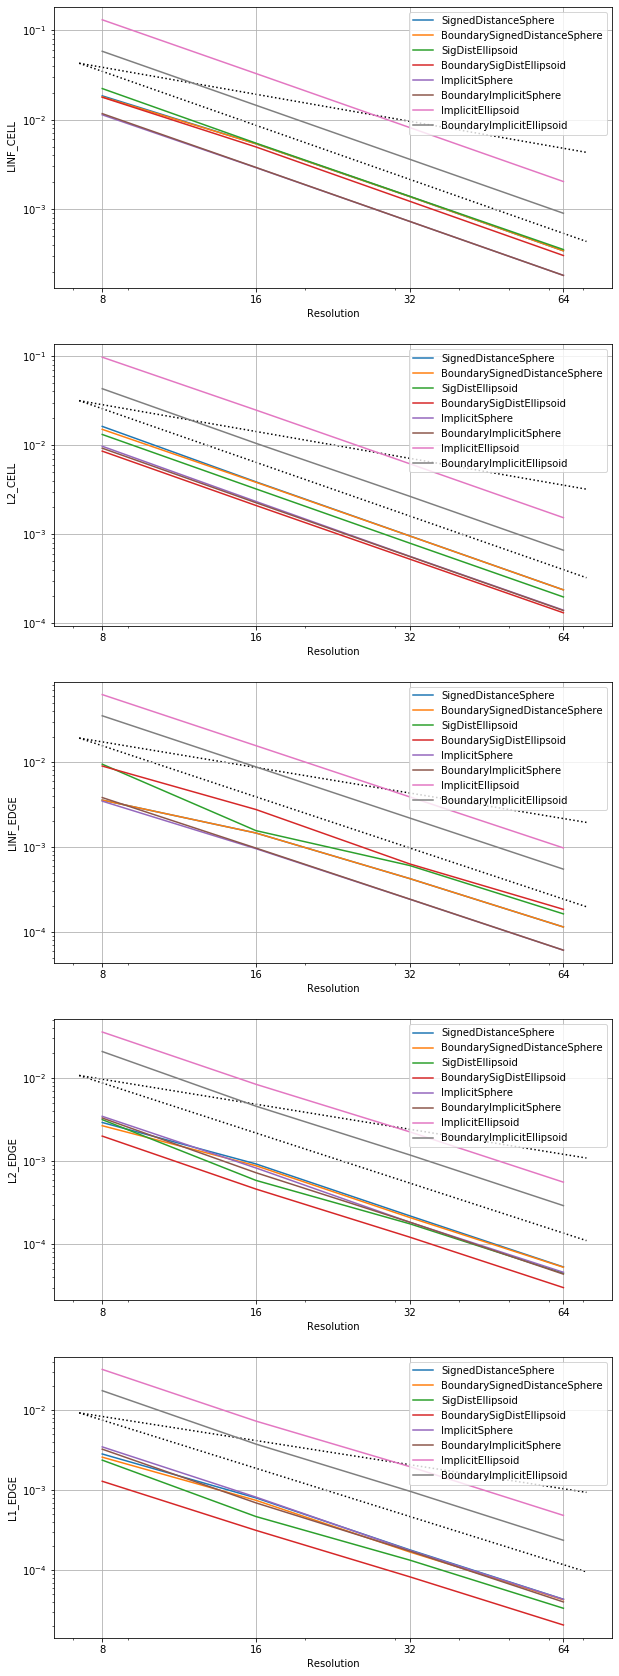

In [2]:
mpld3.enable_notebook()

noPlane = list(surfaces)
noPlane.remove("SignedDistancePlane")
metrics = [' LINF_CELL', ' L2_CELL', 'LINF_EDGE', 'L2_EDGE', 'L1_EDGE']
nplots = len(metrics)
fig, ax = plt.subplots(nplots, 1, figsize=[10,6*nplots])

for idx in range(0,nplots):
    axis = ax[idx]
    metric = metrics[idx]
    
    for surface in noPlane:
        axis.loglog(resolutions, centroiddf.loc[(surface,), metric], label=surface)
    plot_convergence_order(axis, 2)
    axis.set_xticks(resolutions)
    axis.set_xticklabels([str(x) for x in resolutions])
    axis.set_xlabel("Resolution")
    axis.set_ylabel(metric)
    axis.legend()
    axis.grid()

### Rbf positioning tests

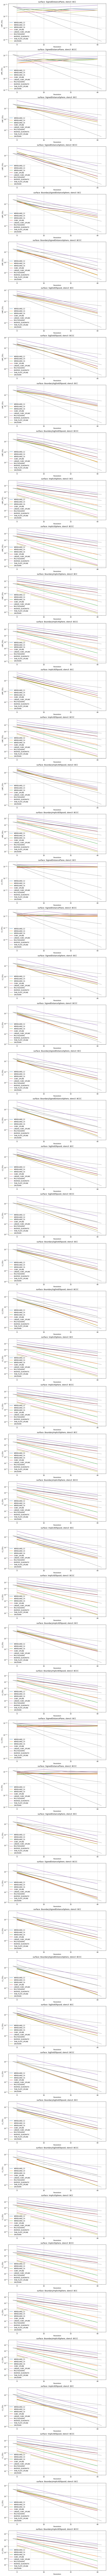

In [3]:
mpld3.enable_notebook()

surface_subset = surfaces #["SignedDistancePlane", "SignedDistanceSphere", "ImplicitEllipsoid", "SigDistEllipsoid"]
metrics = ['LINF_CELL', 'L2_CELL', 'L1_CELL']
nplots = len(surface_subset)*len(metrics)*len(stencils)

fig, ax = plt.subplots(nplots, 1, figsize=[12,6*nplots])
idx = 0

for metric in metrics:
    for surface in surface_subset:
        for stencil in stencils:
            axis = ax[idx]

            for kernel in kernels:
                axis.loglog(resolutions, rbfdf.loc[(stencil,kernel,surface,), metric], label=kernel)
            plot_convergence_order(axis,3)
            axis.set_xticks(resolutions)
            axis.set_xticklabels([str(x) for x in resolutions])
            axis.set_xlabel("Resolution")
            axis.set_ylabel(metric)
            axis.legend()
            axis.grid()
            axis.set_title("surface: " + surface + ", stencil: " + stencil)
            
            idx = idx + 1